# Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import sklearn

# Data Reading

In [2]:
path= 'insurance.csv'
df = pd.read_csv(path)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.duplicated().sum()

np.int64(1)

In [8]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Handling outlier



In [10]:
df['charges']=np.log(df['charges']) # log-transform

# Feature engineering

In [11]:
df['bmi_class'] = pd.cut(
    df['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

In [12]:
df['bmi_smoker'] = df['bmi'] * df['smoker'].map({'yes':1, 'no':0})

In [13]:
df['age_smoker'] = df['age'] * df['smoker'].map({'yes':1, 'no':0})

# Train-test split

In [14]:
features = ['age', 'bmi', 'children', 'sex', 'smoker', 'region',
            'bmi_class', 'bmi_smoker', 'age_smoker']

X = df[features]
y = df['charges']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features = ['age', 'bmi', 'children', 'bmi_smoker', 'age_smoker']
cat_features = ['sex', 'smoker', 'region', 'bmi_class']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])

# Training Models

# LinearRegression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

LR_model = Pipeline([
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

# Predict & reverse log-transform
LR_model.fit(X_train, y_train)
y_pred_lr = np.exp(LR_model.predict(X_test))
y_test_lr = np.exp(y_test)

print("Linear Regression Results:")
print("MAE:", mean_absolute_error(y_test_lr, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)))
print("R2 Score:", r2_score(y_test_lr, y_pred_lr))



Linear Regression Results:
MAE: 2444.1949295558784
RMSE: 4998.388858026556
R2 Score: 0.8390718498246288


# KNN

In [18]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = Pipeline([
    ('prep', preprocess),
    ('knn', KNeighborsRegressor(n_neighbors=5))  # default k = 5
])

knn_model.fit(X_train, y_train)

# Predict & reverse log-transform
y_pred_knn = np.exp(knn_model.predict(X_test))
y_test_knn = np.exp(y_test)

print("KNN Results:")
print("MAE:", mean_absolute_error(y_test_knn, y_pred_knn))
print("RMSE:", np.sqrt(mean_squared_error(y_test_knn, y_pred_knn)))
print("R2 Score:", r2_score(y_test_knn, y_pred_knn))

KNN Results:
MAE: 2322.135552354805
RMSE: 4566.299454756177
R2 Score: 0.8656923601877453


# Improve KNN with Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 15, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan vs Euclidean distance
}

grid = GridSearchCV(knn_model, param_grid,
                    cv=5, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

best_knn = grid.best_estimator_
y_pred_best = np.exp(best_knn.predict(X_test))

print("MAE:", mean_absolute_error(np.exp(y_test), y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(np.exp(y_test), y_pred_best)))
print("R2:", r2_score(np.exp(y_test), y_pred_best))

Best Params: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'distance'}
MAE: 2046.997529988627
RMSE: 4341.00214975089
R2: 0.8786186561199671


# Compare Predictions vs Actuals

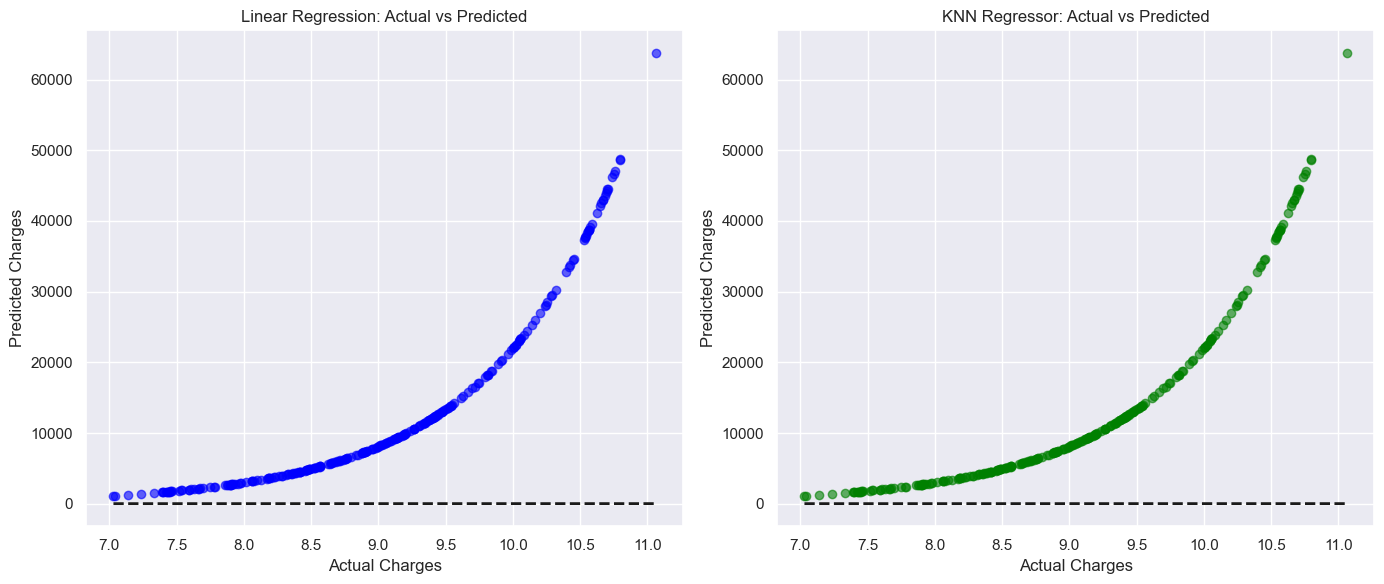

In [20]:
plt.figure(figsize=(14,6))

# Left: Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_lr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Linear Regression: Actual vs Predicted")

# Right: KNN Regressor
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_knn, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("KNN Regressor: Actual vs Predicted")

plt.tight_layout()
plt.show()